In [19]:
import km3io as kio
import km3pipe as kp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

In [20]:
def stop_pos(f_,cuts_,track) :
    
    start_pos = [f_.events.tracks.pos_x[track][cuts_][:,0].__array__(),
                 f_.events.tracks.pos_y[track][cuts_][:,0].__array__(),
                 f_.events.tracks.pos_z[track][cuts_][:,0].__array__()]
    
    start_pos = np.stack(start_pos)

    tracklength = f_.events.tracks.fitinf[track][cuts_][:,0,10].__array__()

    stop_pos = np.stack([start_pos[0,:] + f_.events.tracks.dir_x[track][cuts_][:,0].__array__() * tracklength,
                        start_pos[1,:] + f_.events.tracks.dir_y[track][cuts_][:,0].__array__() * tracklength,
                        start_pos[2,:] + f_.events.tracks.dir_z[track][cuts_][:,0].__array__() * tracklength])
    
    return stop_pos, start_pos, tracklength

def stop_pos_true(f_,cuts_,true_arr) :
    
    start_pos = [f_.events.mc_tracks.pos_x[cuts_][:,0].__array__(),
                 f_.events.mc_tracks.pos_y[cuts_][:,0].__array__(),
                 f_.events.mc_tracks.pos_z[cuts_][:,0].__array__()]
    
    start_pos = np.stack(start_pos)

    tracklength = np.array(np.abs(true_arr["muon_true_len"]))[cuts_]

    stop_pos = np.stack([start_pos[0,:] + f_.events.mc_tracks.dir_x[cuts_][:,0].__array__() * tracklength,
                        start_pos[1,:] + f_.events.mc_tracks.dir_y[cuts_][:,0].__array__() * tracklength,
                        start_pos[2,:] + f_.events.mc_tracks.dir_z[cuts_][:,0].__array__() * tracklength])
    
    return stop_pos, start_pos, tracklength


In [21]:
def DOM():
    """Reads DOM file and store list of positions, ids and dictionary"""


    #Read DOMS information on positions and id
    det = kp.hardware.Detector('/home/celestin/Documents/km3netdata_internship/ARCA/KM3NeT_00000075_20220408.detx')
    
    #Store position of DOMS in a np.array ([xxx][yyyy][zzzz])
    dom_x = []
    dom_y = []
    dom_z = []
    dom_id = []

    for dom,pos in det.dom_positions.items():
        dom_x.append(pos[0])
        dom_y.append(pos[1])
        dom_z.append(pos[2])
        dom_id.append(dom)
    
    dom_positions = np.array((dom_x,dom_y,dom_z))

    #Transpose the arrays to make a for loop for each distance
    dom_positions_bis = dom_positions.T
    

    #create dictionary of id vs index
    dict_id = {}
    for i in range(len(dom_positions_bis)):
        dict_id[i] = dom_id[i]
        
    return dom_positions_bis, dict_id

In [22]:
def plot3D(stop_pos,dom_positions,title=False):
    """Plots the stop positions in a 3D plot"""
    
    #3D plot stop positions cuts_bis

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection='3d')

    x = stop_pos[0]
    y = stop_pos[1]
    z = stop_pos[2]
    
    ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
    ax.scatter3D(x, y, z,s=0.5,depthshade=False, marker=".",label="first")

    if type(title) != bool :
        ax.set_title(title)
    else :
        ax.set_title("Stop Positions")
    
    return ax

In [23]:
def plot1var(df,var,var_min=False,var_max=False,logscale_x=False,logscale_y=False,title=False) :
    fig, ax = plt.subplots (figsize = (7,7))
    
    if type(var_min) != bool and type(var_max) != bool :
        min_x = var_min
        max_x = var_max
    else :
        min_x = df[var].min()
        max_x = df[var].max()
        
    if logscale_x:
        ax.set_xscale('log')

    if logscale_y :
        ax.set_yscale('log')
        
    bins=np.linspace(min_x,max_x,150)
        
    ax.hist(df[var],bins)
    ax.set_xlabel(f'{var}')
    ax.set_xlim(min_x,max_x)
    
    if type(title) != bool :
        ax.set_title(title)
    else :
        ax.set_title(f'{var}')

    return ax

In [24]:
def plot1var_subplot(var,var_min=False,var_max=False,ymin=False,ymax=False,logscale_x=False,logscale_y=False,title=False) :

    nvar = len(var)

    if type(var_min) != bool and type(var_max) != bool :
        min_x = var_min
        max_x = var_max
    else :
        min_x = var[0].min()
        max_x = var[0].max()

    bins=np.linspace(min_x,max_x,150)

    fig, ax = plt.subplots(nvar,1)
    
    for i in range(nvar) :
        ax[i].hist(var[i],bins)
        if ymin != False and ymax != False :
            ax[i].set_yrange([0,4000])
        if type(title) != bool :
            ax[i].set_title(title[i])
        else :
            ax[i].set_title(f'{var[i]}')
        if logscale_x == True :
            ax[i].set_xscale('log')
        if logscale_y == True :
            ax[i].set_yscale('log')


    fig.tight_layout()

    return ax

In [25]:
def plot1var_overplot(df,var,var_min=False,var_max=False,logscale_x=False,logscale_y=False,title=False,var_names=False) :

    nvar = len(df)

    if type(var_min) != bool and type(var_max) != bool :
        min_x = var_min
        max_x = var_max
    else :
        min_x = df[0][var].min()
        max_x = df[0][var].max()

    bins=np.linspace(min_x,max_x,150)

    fig, ax = plt.subplots(figsize=(5,5))
    
    for i in range(nvar) :
        ax.hist(df[i][var],bins,label=var_names[i],histtype='step')
    if type(title) != bool :
        ax.set_title(title)
    else :
        ax.set_title(f'{var[0]}')
    if logscale_x == True :
        ax.set_xscale('log')
    if logscale_y == True :
        ax.set_yscale('log')
    ax.set_xlabel(f'{var}')
    ax.legend()

    fig.tight_layout()

    return ax

In [26]:
def plot1var_overplot_log(df,var,var_min=False,var_max=False,logscale_x=False,logscale_y=False,title=False,var_names=False) :

    nvar = len(df)

    if type(var_min) != bool and type(var_max) != bool :
        min_x = var_min
        max_x = var_max
    else :
        min_x = df[0][var].min()
        max_x = df[0][var].max()

    bins=np.linspace(min_x,max_x,200)

    fig, [ax, bx] = plt.subplots(figsize=(10,5),nrows=1,ncols=2)
    
    for i in range(nvar) :
        ax.hist(df[i][var],bins,label=var_names[i],histtype='step')
        bx.hist(df[i][var],bins,label=var_names[i],histtype='step')
    if type(title) != bool :
        ax.set_title(title)
        bx.set_title(title)
    else :
        ax.set_title(f'{var[0]}')
        bx.set_title(f'{var[0]}')
    if logscale_x == True :
        bx.set_xscale('log')
    if logscale_y == True :
        bx.set_yscale('log')
    ax.set_xlabel(f'{var}')
    bx.set_xlabel(f'{var}')
    ax.legend()
    bx.legend()

    fig.tight_layout()

    return [ax,bx]

In [27]:
def plot2var(df,var1,var2,var1_min=False,var2_min=False,var1_max=False,var2_max=False,logscale_x=False,logscale_y=False) :
    
    fig, ax = plt.subplots (figsize = (7,7))

    if type(var1_min) != bool and type(var1_max) != bool :
        min_x = var1_min
        max_x = var1_max
    else :
        min_x = df[var1].min()
        max_x = df[var1].max()

    if type(var2_min) != bool and type(var2_max) != bool :
        min_y = var2_min
        max_y = var2_max
    else :
        min_y = df[var2].min()
        max_y = df[var2].max()
    
    if logscale_x:
        ax.set_xscale('log')
    bins_x=np.linspace(min_x,max_x,500)

    if logscale_y :
        ax.set_yscale('log')
    bins_y = np.linspace(min_y,max_y, 500)

    h2=ax.hist2d(df[var1],df[var2],bins=[bins_x,bins_y],norm=mpl.colors.LogNorm())
    ax.set_xlabel(f'{var1}')
    ax.set_ylabel(f'{var2}')
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)
    ax.set_title(f'{var1} vs {var2}')
    fig.colorbar(h2[3])
    

    return h2

In [28]:
def plot2var_subplot(df,var1,var2,var1_min=False,var2_min=False,var1_max=False,var2_max=False,logscale_x=False,logscale_y=False,title=False) :
    
    nvar = len(df)

    plt.figure(figsize = (7,4*nvar))

    if type(var1_min) != bool and type(var1_max) != bool :
        min_x = var1_min
        max_x = var1_max
    else :
        min_x = df[0][var1].min()
        max_x = df[0][var1].max()

    if type(var2_min) != bool and type(var2_max) != bool :
        min_y = var2_min
        max_y = var2_max
    else :
        min_y = df[0][var2].min()
        max_y = df[0][var2].max()
    
    
    bins_x=np.linspace(min_x,max_x,150)

    
    bins_y = np.linspace(min_y,max_y, 150)

    for i in range(nvar) :
        plt.subplot(nvar,1,i+1)
        if logscale_x:
            plt.xscale('log')
        if logscale_y :
            plt.yscale('log')
        h2 = plt.hist2d(df[i][var1],df[i][var2],bins=[bins_x,bins_y],norm=mpl.colors.LogNorm())
        plt.xlabel(f'{var1}')
        plt.ylabel(f'{var2}')
        plt.colorbar(h2[3])
        if type(title) != bool :
            plt.title(title[i])

        plt.tight_layout()

    return

In [29]:
def plot2var_scatter(df,var1,var2,var1_min=False,var2_min=False,var1_max=False,var2_max=False,logscale_x=False,logscale_y=False,title=False,s=1) :
    
    if len(df) != 1 :
        n = len(df)
    else : 
        n = 1

    plt.figure(figsize = (7,7))

    for i in range(n) :
        plt.subplot(n,1,i+1)
        if logscale_x:
            plt.xscale('log')
        if logscale_y :
            plt.yscale('log')
        h2 = plt.plot(df[i][var1],df[i][var2],"o",markersize=s)
        plt.xlabel(f'{var1}')
        plt.ylabel(f'{var2}')
        if type(title) != bool :
            plt.title(title[i])
        if type(var1_min) != bool and type(var1_max) != bool :
            plt.xlim(var1_min,var1_max)
        if type(var2_min) != bool and type(var2_max) != bool :
            plt.ylim(var2_min,var2_max)
        plt.tight_layout()

    return

In [30]:
def linear(x1,y1,x2,y2) :
    m = (y1-y2)/(x1-x2)
    p = y1 - m * x1
    return m,p

In [31]:
def VolumeCut_cube(pos_stop,marg=0,z_inf=0,z_sup=0):
    """Returns boolean list for cut based on stop positions inside a given volume, plus cuts in each direction
    Returns also the stop positions as a list of coordinates"""

    #Compute cuts_volume
    cuts_volume = []    
    
    #Define limits of our volume, taking into account the cut in each direction
    x_lim = [-29.5-marg,249.2+marg]
    y_lim = [107.05-marg,214.4+marg]
    z_lim = [0+z_inf,689.164-z_sup]

    #Loop over all events
    coordinates = []

    pos_stop=pos_stop.T
    
    for i in range(len(pos_stop)):   
        
        x,y,z = pos_stop[i,0],pos_stop[i,1],pos_stop[i,2] #coordinates of points of the events
            
        if (z >= z_lim[0]) and (z <= z_lim[1]): #check if in z range
            
            if (y >= y_lim[0]) and (y <= y_lim[1]):  #check if in y range
                
                if (x >= x_lim[0]) and (x <= x_lim[1]):
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])                   

                else:
                    cuts_volume.append(False)

            else:
                cuts_volume.append(False)
                
        else:
            cuts_volume.append(False)


    return cuts_volume, coordinates

In [32]:
def VolumeCut(pos_stop,z_inf=0,z_sup=0):
    """Returns boolean list for cut based on stop positions inside a given volume, plus cuts in each direction
    Returns also the stop positions as a list of coordinates"""

    #Compute cuts_volume
    cuts_volume = []
    
    z_lim = [0+z_inf,689.164-z_sup]
    
    m1,p1 = linear(-29.5,204.2,249.2,214.4)
    m2,p2 = linear(172.8,130.8,249.2,214.4)
    m3,p3 = linear(-29.5,204.2,51.85,180.35)
    m4,p4 = linear(51.85,180.35,116.9,107.05)
    m5,p5 = linear(116.9,107.05,172.8,130.8)

    coordinates = []
    pos_stop = pos_stop.T

    for i in range(len(pos_stop)):   
        
        x,y,z = pos_stop[i,0],pos_stop[i,1],pos_stop[i,2] #coordinates of points of the events
            
        if (z >= z_lim[0]) & (z <= z_lim[1]): #check if in z range
            
            if y >= 204.2 and y < 214.4 and x >= -29.5 and x <= 249.2  :
                ya=m1*x+p1
                xa=(y-p2)/m2
                if y<ya and x<xa :
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                else :
                    cuts_volume.append(False)
            
            elif (y <= 204.2) & (y >= 180.35) & (x >= -29.5) & (x <= 249.2) :
                xa=(y-p3)/m3
                xb=(y-p2)/m2
                if x>=xa and x<= xb :
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                else :
                    cuts_volume.append(False)

            elif (y <= 180.35) & (y >= 130.8) & (x >= 51.85) & (x <= 249.2) :
                xa=(y-p4)/m4
                xb=(y-p2)/m2
                if x>=xa and x<=xb :
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                else :
                    cuts_volume.append(False)

            elif (y <= 130.8) & (y >= 107.05) & (x >= 51.85) & (x <= 172.8) :
                xa=(y-p4)/m4
                xb=(y-p5)/m5
                if x>=xa and x<= xb :
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                else :
                    cuts_volume.append(False)

            else:
                cuts_volume.append(False)
                
        else:
            cuts_volume.append(False)


    return cuts_volume, coordinates

In [33]:
def newpos(f,haveTrk,cuts_2,cuts_volume, complete = True):
    """For a given list of cut boolans lists, computes the strat, stop and track lenght positions"""
    
    
    #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
    pos_start = [f.events.tracks.pos_x[haveTrk][cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_y[haveTrk][cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_z[haveTrk][cuts_2][cuts_volume][:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start = np.stack(pos_start)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength = f.events.tracks.fitinf[haveTrk][cuts_2][cuts_volume][:,0,10].__array__()
        
    if complete :
        #stop postion, as pos start + track
        pos_stop_x  = pos_start[0,:] + f.events.tracks.dir_x[haveTrk][cuts_2][cuts_volume][:,0].__array__() * trackLength
        pos_stop_y  = pos_start[1,:] + f.events.tracks.dir_y[haveTrk][cuts_2][cuts_volume][:,0].__array__() * trackLength
        pos_stop_z  = pos_start[2,:] + f.events.tracks.dir_z[haveTrk][cuts_2][cuts_volume][:,0].__array__() * trackLength

        #Add all positions together, array of arrays
        pos_stop = np.stack((pos_stop_x, pos_stop_y, pos_stop_z))
            
        return pos_start, trackLength, pos_stop
        
    else:
        return pos_start, trackLength

def newpos_true(f,true_arr, complete = True):
    """For a given list of cut boolans lists, computes the strat, stop and track lenght positions"""

    #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
    pos_start = [f.events.mc_tracks.pos_x[:,0].__array__(),f.events.mc_tracks.pos_y[:,0].__array__(),f.events.mc_tracks.pos_z[:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start = np.stack(pos_start)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength = np.array(np.abs(true_arr["muon_true_len"]))
        
    if complete :
        #stop postion, as pos start + track
        pos_stop_x  = pos_start[0,:] + f.events.mc_tracks.dir_x[:,0].__array__() * trackLength
        pos_stop_y  = pos_start[1,:] + f.events.mc_tracks.dir_y[:,0].__array__() * trackLength
        pos_stop_z  = pos_start[2,:] + f.events.mc_tracks.dir_z[:,0].__array__() * trackLength

        #Add all positions together, array of arrays
        pos_stop = np.stack((pos_stop_x, pos_stop_y, pos_stop_z))
            
        return pos_start, trackLength, pos_stop
        
    else:
        return pos_start, trackLength

In [34]:
def cuts(file,E=2,lik=0,dir_z=0,zsup=0,zinf=0,EL=False) :
    
    f = kio.OfflineReader(file)
    
    n_events = len(f.events)

    haveTrk = np.array(f.events.n_tracks, dtype=bool)

    if type(EL) != bool :
        cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)) & ((f.events.tracks.E[haveTrk][:,0]/f.events.tracks.fitinf[haveTrk][:,0,10]) <= EL)
    else :
        cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z))

    #Call pos_stop function to compute stop postions based on cuts_2, as well as start positions and tracklength
    pos_stop, pos_start, trackLength = stop_pos(f,cuts,haveTrk)
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume = VolumeCut(pos_stop,zinf,zsup)[0]

    filtered_events = f.events[haveTrk][cuts][cuts_volume]

    print(filtered_events)

    pos_start, trackLength, pos_stop = newpos(f,haveTrk,cuts,cuts_volume, cuts_length = 0, complete = True)
    
    #Calculate % of filtered events
    n_filtered_events = len(filtered_events)
    print(str("{:.2f}".format((n_events-n_filtered_events)*100/n_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if n_filtered_events == 0. :
        print("Filtration finished, any event selected")
    
    else :
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.tracks.fitinf[:,0,3].__array__(),filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start[0],pos_start[1],pos_start[2],trackLength,pos_stop[0],pos_stop[1],pos_stop[2],filtered_events.events.tracks.E[:,0].__array__()/trackLength,filtered_events.events.tracks.t[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__()/filtered_events.events.tracks.fitinf[:,0,3].__array__()))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','frame_index','trigger_counter','n_hits','hits_id','hits_amplitude','hits_channel_id','hits_dom_id','hits_t','hits_tdc','hits_pos_x','hits_pos_y','hits_pos_z','hits_dir_x','hits_dir_y','hits_dir_z','hits_tot','hits_trig','t_sec','t_ns','t_track','E_GeV',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","L","stop_x","stop_y","stop_z","E/L","t","lik/hit"])


        return df_cuts

In [35]:
def cuts_range(file,range_inf,range_sup,E=2,lik=0,dir_z=0,zsup=0,zinf=0,EL=False,margin=0,LH=False) :
    
    f = kio.OfflineReader(file)[int(range_inf):int(range_sup)]
    
    n_events = len(f.events)

    haveTrk = np.array(f.events.n_tracks, dtype=bool)

    if type(EL) != bool :
        if type(LH) != bool :
            print('ICI')
            cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z) & ((f.events.tracks.E[haveTrk][:,0]/f.events.tracks.fitinf[haveTrk][:,0,10]) <= EL) & (f.events.tracks.lik[haveTrk][:,0]/f.events.tracks.fitinf[haveTrk][:,0,3] >= LH))
        else : 
            cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z) & (f.events.tracks.E[haveTrk][:,0]/f.events.tracks.fitinf[haveTrk][:,0,10]) <= EL)    
    else : 
        if type(LH) != bool :
            cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z) & ((f.events.tracks.lik[haveTrk][:,0]/f.events.tracks.fitinf[haveTrk][:,0,3]) >= LH))
        else : 
            cuts = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik) & (f.events.tracks.dir_z[haveTrk][:,0] <= dir_z))    

    

    #Call pos_stop function to compute stop postions based on cuts_2, as well as start positions and tracklength
    pos_stop, pos_start, trackLength = stop_pos(f,cuts,haveTrk)
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume = VolumeCut_cube(pos_stop,z_inf=zinf,z_sup=zsup,marg=margin)[0]

    filtered_events = f.events[haveTrk][cuts][cuts_volume]

    print(filtered_events)

    pos_start, trackLength, pos_stop = newpos(f,haveTrk,cuts,cuts_volume, complete = True)
    
    #Calculate % of filtered events
    n_filtered_events = len(filtered_events)
    print(str("{:.2f}".format((n_events-n_filtered_events)*100/n_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if n_filtered_events == 0. :
        print("Filtration finished, any event selected")
    
    else :
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.tracks.fitinf[:,0,3].__array__(),filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start[0],pos_start[1],pos_start[2],trackLength,pos_stop[0],pos_stop[1],pos_stop[2],filtered_events.events.tracks.E[:,0].__array__()/trackLength,filtered_events.events.tracks.t[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__()/filtered_events.events.tracks.fitinf[:,0,3].__array__()))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','frame_index','trigger_counter','n_hits','hits_id','hits_amplitude','hits_channel_id','hits_dom_id','hits_t','hits_tdc','hits_pos_x','hits_pos_y','hits_pos_z','hits_dir_x','hits_dir_y','hits_dir_z','hits_tot','hits_trig','t_sec','t_ns','t_track','E_GeV',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","L","stop_x","stop_y","stop_z","E/L","t","lik/hit"])

        return df_cuts

def cuts_range_true(file,range_inf,range_sup,E=2,dir_z=0,zsup=0,zinf=0,margin=0,EL=False) :
        
    aliases = {'muon_true_len':'sum_mc_trks/tmuon/tmuon.len', 'muon_true_ntracks':'sum_mc_trks/ntrks',
            'muon_scaling':'sum_mc_evt/weight',
            'muon_true_nhits': 'sum_mc_hits/nhits', 'muon_reco_nhits': 'sum_hits/nhits',
            'muon_true_atot': 'sum_mc_hits/atot', 'muon_reco_atot': 'sum_hits/atot'}

    #Read file using kio
    f = kio.OfflineReader(file)[int(range_inf):int(range_sup)]

    # Get true track length (not needed here) and number of muons in bundle for other tree in file
    true_arr = f._fobj['T'].arrays(aliases.keys(), aliases = aliases)[int(range_inf):int(range_sup)]

    # Pre-cut to get only 1-muon events (no bundle)
    cuts_bundle = true_arr["muon_true_ntracks"]==1
    f = f[cuts_bundle]
    true_arr=true_arr[cuts_bundle]
    n_events = np.sum(cuts_bundle)
    
    cuts = np.array((f.events.mc_tracks.E[:,0] >= E) & (f.events.mc_tracks.dir_z[:,0] <= dir_z))
    
    #Call pos_stop function to compute stop postions based on cuts_2, as well as start positions and tracklength
    pos_stop, pos_start, trackLength = stop_pos_true(f,cuts,true_arr=true_arr)
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume = VolumeCut_cube(pos_stop,z_inf=zinf,z_sup=zsup,marg=margin)[0]

    filtered_events = f.events[cuts][cuts_volume]

    print(filtered_events)

    true_arr = true_arr[cuts][cuts_volume]

    pos_start, trackLength, pos_stop = newpos_true(filtered_events,true_arr, complete = True)
    
    #Calculate % of filtered events
    n_filtered_events = len(filtered_events)
    print(str("{:.2f}".format((n_events-n_filtered_events)*100/n_events))+"% of events filtered")
    
    #Exception in case any event is selected
    if n_filtered_events == 0. :
        print("Filtration finished, any event selected")
    
    else :
        data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.t_sec,filtered_events.t_ns,filtered_events.mc_tracks.t[:,0].__array__(),filtered_events.events.mc_tracks.E[:,0].__array__(),filtered_events.events.mc_tracks.dir_x[:,0].__array__(),filtered_events.events.mc_tracks.dir_y[:,0].__array__(),filtered_events.events.mc_tracks.dir_z[:,0].__array__(),pos_start[0],pos_start[1],pos_start[2],trackLength,pos_stop[0],pos_stop[1],pos_stop[2],filtered_events.events.tracks.E[:,0].__array__()/trackLength))
        df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','frame_index','trigger_counter','t_sec','t_ns','t_track','E_GeV',"dir_x","dir_y","dir_z","start_x","start_y","start_z","L","stop_x","stop_y","stop_z","E/L"])
        
        return df_cuts


In [36]:
if __name__ == "__main__" :

    fileName = '/home/celestin/Documents/km3netdata_internship/ARCA_new/new/data.v7.0.jchain.arca.aashower.95_dst_merged.root'
    df1_cut_z = 0
    df_1 = cuts_range(fileName,range_inf=0,range_sup=10e6,dir_z=df1_cut_z,zinf=0,zsup=0,E=1,lik=0,margin=100,LH=1.5)

/home/celestin/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


<OfflineReader [295879/108811726] path='E/Evt'>
97.04% of events filtered


/tmp/ipykernel_12395/4210922676.py:44: RuntimeWarning: divide by zero encountered in true_divide
  data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.tracks.fitinf[:,0,3].__array__(),filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start[0],po

In [37]:
    fileName = '/home/celestin/Documents/km3netdata_internship/ARCA_new/mc.v7.0.1.mupage_100G.sirene.9X_10X_dst_merged.root'    
    df2_cut_z = 0
    df_2 = cuts_range(fileName,range_inf=0,range_sup=1e6,dir_z=df2_cut_z,zinf=0,zsup=0,E=1,lik=0,margin=100,LH=1.5)

/home/celestin/.local/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(


<OfflineReader [137506/35907062] path='E/Evt'>
86.25% of events filtered


/tmp/ipykernel_12395/4210922676.py:44: RuntimeWarning: divide by zero encountered in true_divide
  data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.frame_index,filtered_events.trigger_counter,filtered_events.tracks.fitinf[:,0,3].__array__(),filtered_events.hits.id,filtered_events.hits.a,filtered_events.hits.channel_id,filtered_events.hits.dom_id,filtered_events.hits.t,filtered_events.hits.tdc,filtered_events.hits.pos_x,filtered_events.hits.pos_y,filtered_events.hits.pos_z,filtered_events.hits.dir_x,filtered_events.hits.dir_y,filtered_events.hits.dir_z,filtered_events.hits.tot,filtered_events.hits.trig,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.t[:,0].__array__(),filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start[0],po

In [38]:
    df3_cut_z = 0
    df_3 = cuts_range_true(fileName,range_inf=0,range_sup=1e6,dir_z=df2_cut_z,zinf=0,zsup=0,E=1,margin=100)

<OfflineReader [146998/35907062] path='E/Evt'>
74.21% of events filtered


2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.


++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 WARNING ++ km3pipe.hardware: DOMs with different number of PMTs are detected, this can cause some unexpected behaviour.
2022-06-05 19:43:09 

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.
++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


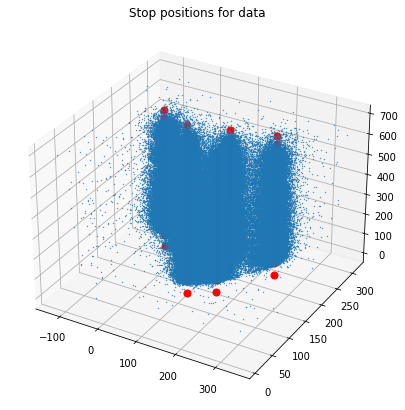

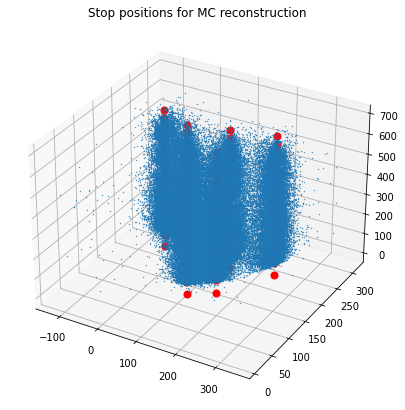

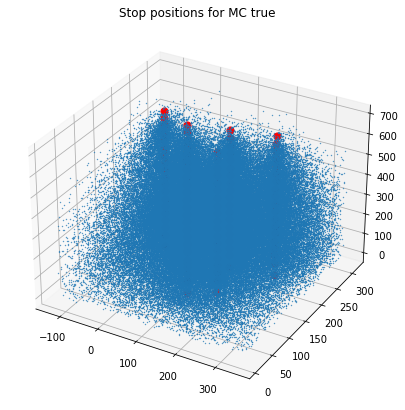

In [39]:
    # stop muons positions
    plot3D([df_1['stop_x'],df_1['stop_y'],df_1['stop_z']],DOM()[0],title='Stop positions for data')
    plot3D([df_2['stop_x'],df_2['stop_y'],df_2['stop_z']],DOM()[0],title='Stop positions for MC reconstruction')
    plot3D([df_3['stop_x'],df_3['stop_y'],df_3['stop_z']],DOM()[0],title='Stop positions for MC true')

    plt.show()

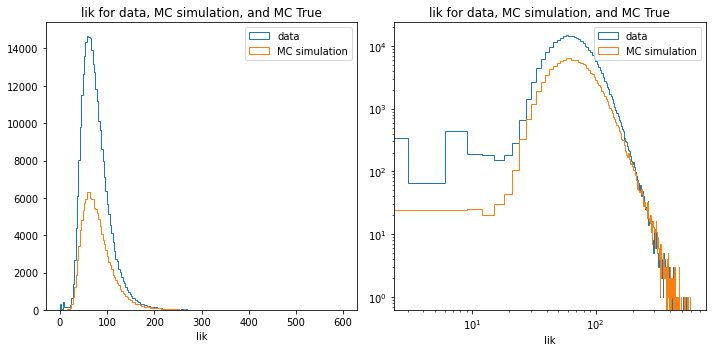

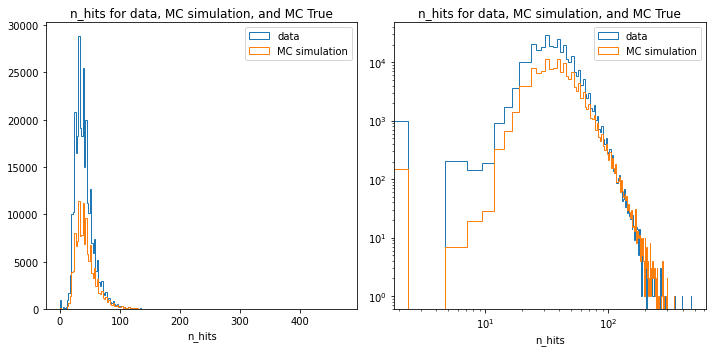

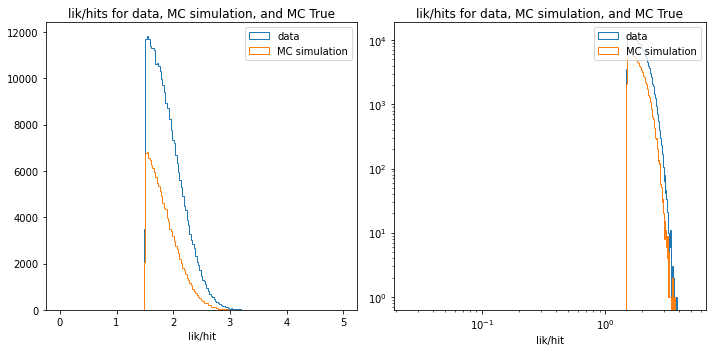

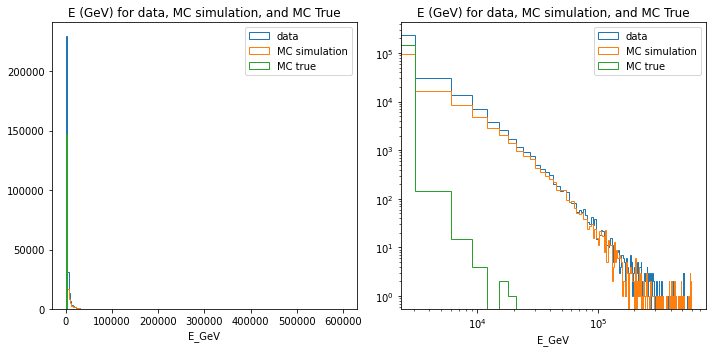

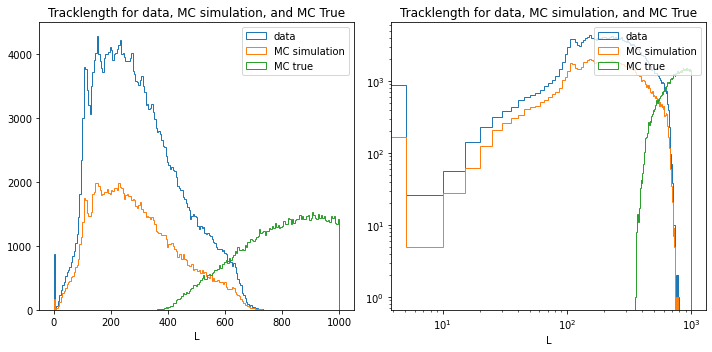

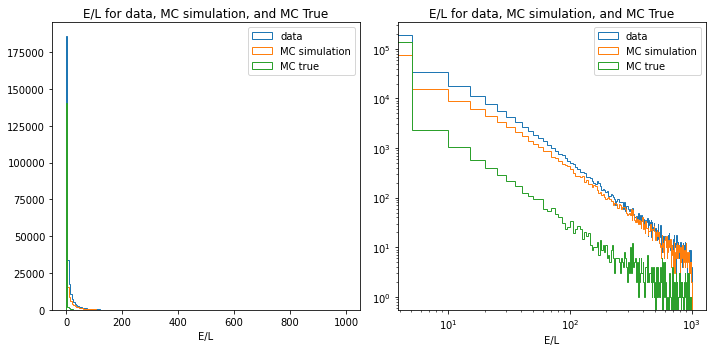

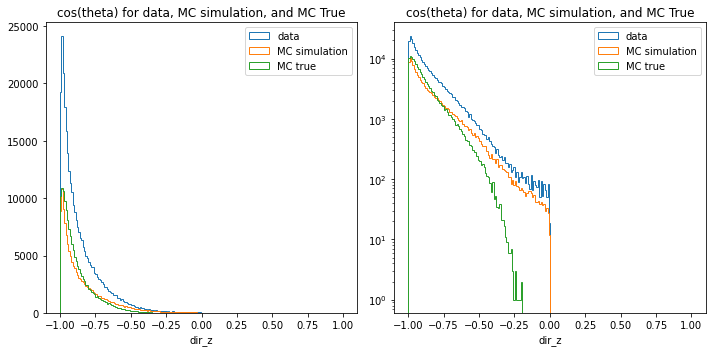

In [40]:
    #   Simple histograms
    
    plot1var_overplot_log([df_1,df_2],var='lik',var_min=0,var_max=600,logscale_x=True,logscale_y=True,title='lik for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot_log([df_1,df_2],'n_hits',logscale_x=True,logscale_y=True,title='n_hits for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot_log([df_1,df_2],'lik/hit',var_min=0,var_max=5,logscale_x=True,logscale_y=True,title='lik/hits for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])

    plot1var_overplot_log([df_1,df_2,df_3],var='E_GeV',var_min=0,var_max=0.6e6,logscale_x=True,logscale_y=True,title='E (GeV) for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot_log([df_1,df_2,df_3],var='L',var_min=0,var_max=1000,logscale_x=True,logscale_y=True,title='Tracklength for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot_log([df_1,df_2,df_3],var='E/L',var_min=0,var_max=1000,logscale_x=True,logscale_y=True,title='E/L for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot_log([df_1,df_2,df_3],var='dir_z',var_min=-1,var_max=1,logscale_y=True,title='cos(theta) for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
 

    plt.show()

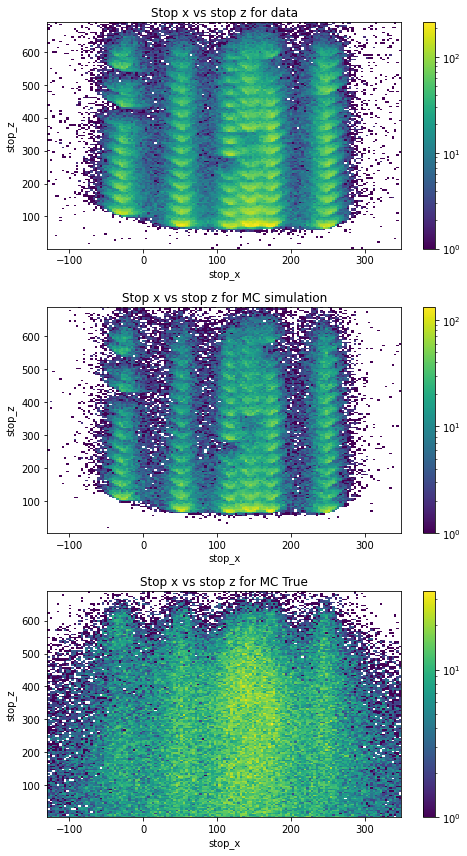

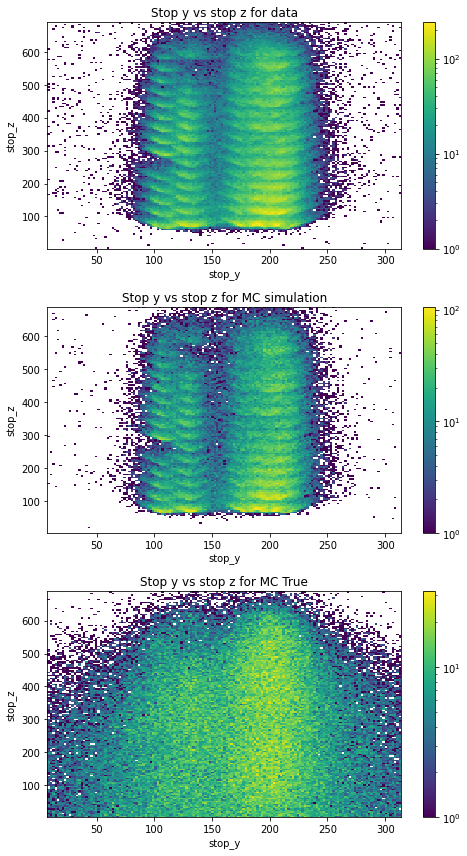

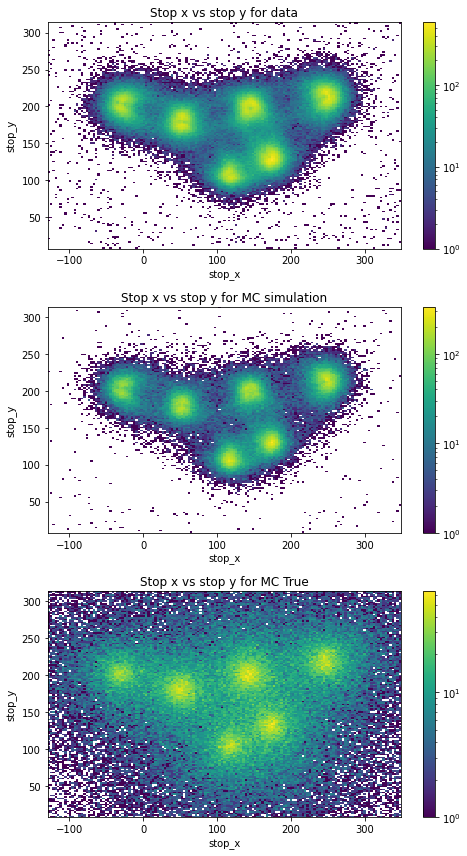

In [41]:
    #   Plots of positions

    plot2var_subplot([df_1,df_2,df_3],'stop_x','stop_z',title=['Stop x vs stop z for data','Stop x vs stop z for MC simulation','Stop x vs stop z for MC True'])
    plot2var_subplot([df_1,df_2,df_3],'stop_y','stop_z',title=['Stop y vs stop z for data','Stop y vs stop z for MC simulation','Stop y vs stop z for MC True'])
    plot2var_subplot([df_1,df_2,df_3],'stop_x','stop_y',title=['Stop x vs stop y for data','Stop x vs stop y for MC simulation','Stop x vs stop y for MC True'])

    plt.show()

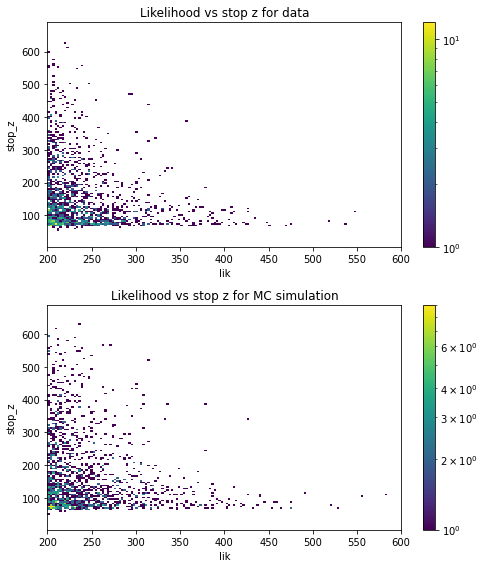

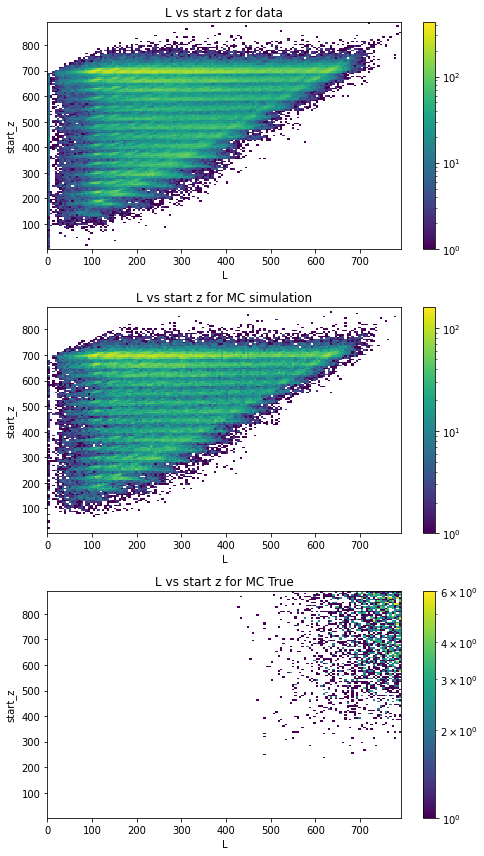

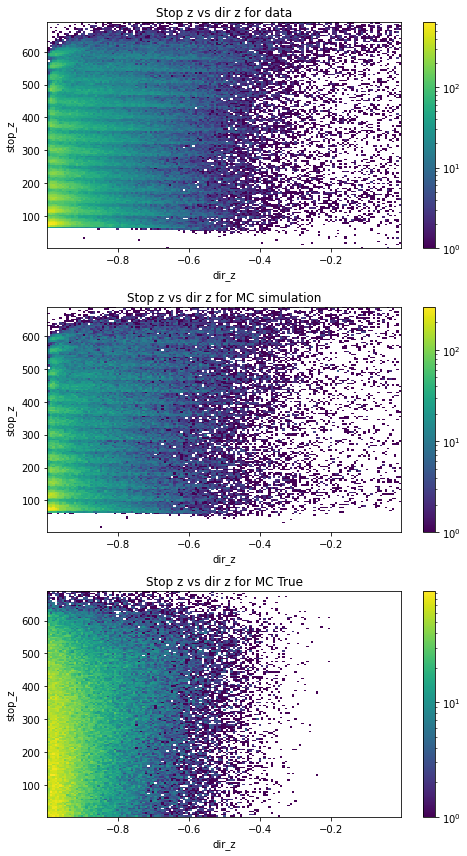

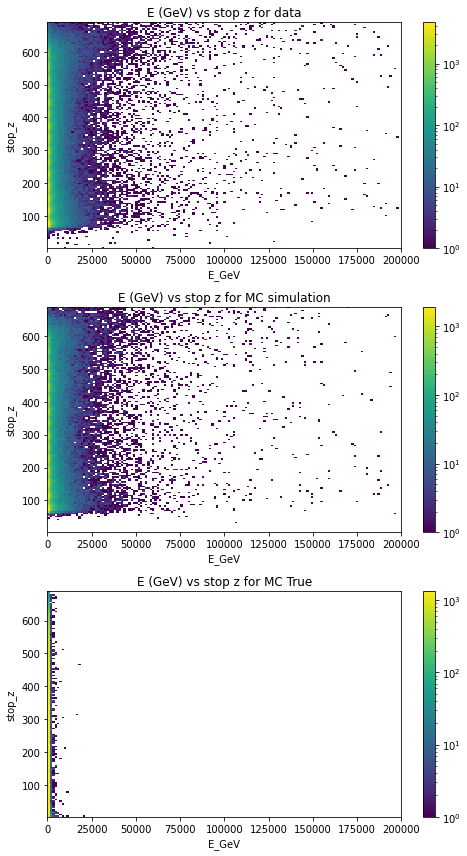

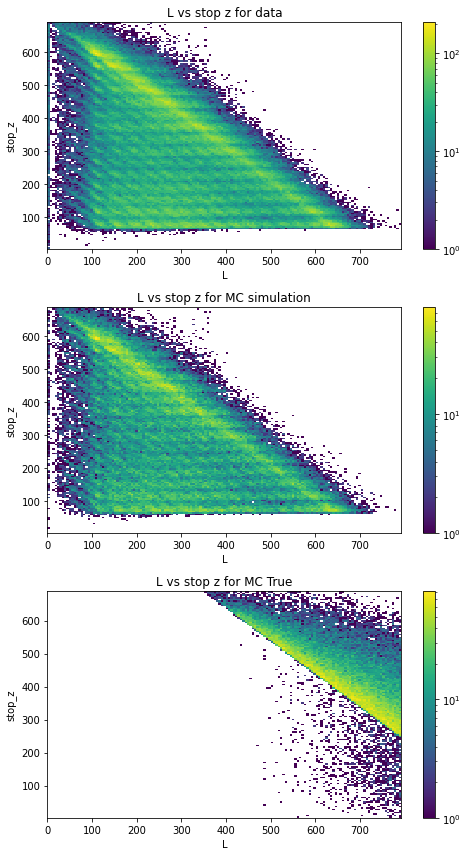

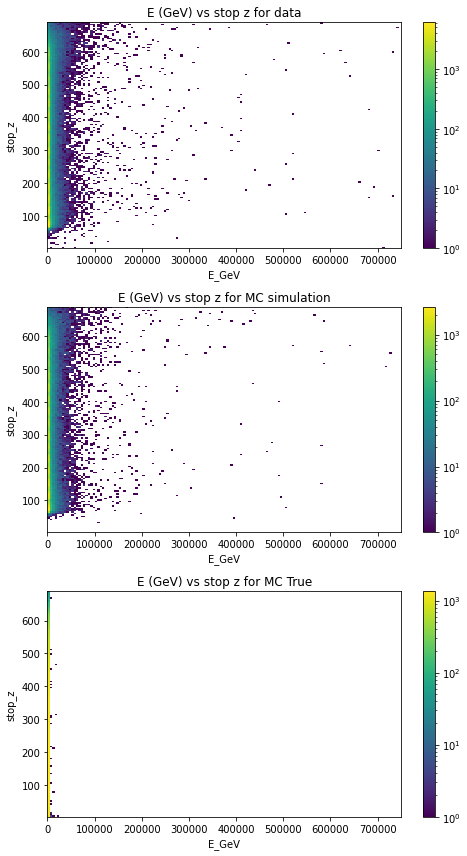

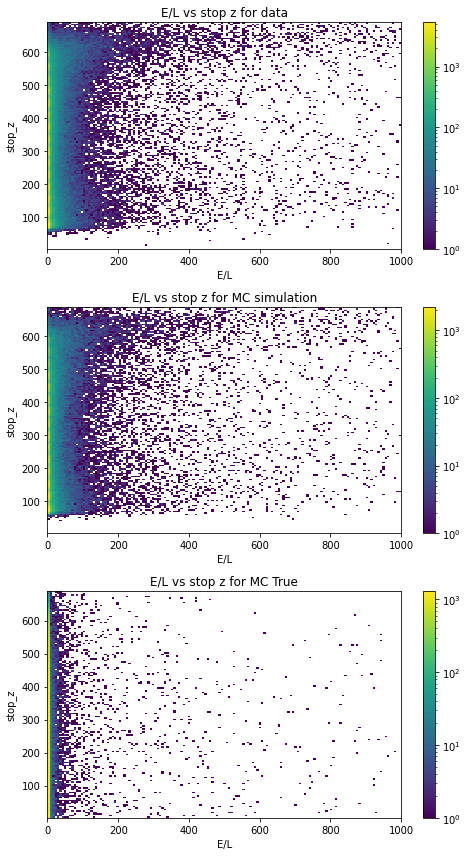

In [42]:
    #   Plots vs position

    plot2var_subplot(df=[df_1,df_2],var1='lik',var2='stop_z',var1_min=200,var1_max=600,title=['Likelihood vs stop z for data','Likelihood vs stop z for MC simulation'])

    plot2var_subplot(df=[df_1,df_2,df_3],var1='L',var2='start_z',title=['L vs start z for data','L vs start z for MC simulation','L vs start z for MC True'])
    
    plot2var_subplot(df=[df_1,df_2,df_3],var1='dir_z',var2='stop_z',title=['Stop z vs dir z for data','Stop z vs dir z for MC simulation','Stop z vs dir z for MC True'])
    plot2var_subplot(df=[df_1,df_2,df_3],var1='E_GeV',var2='stop_z',var1_min=0,var1_max=2e5,title=['E (GeV) vs stop z for data','E (GeV) vs stop z for MC simulation','E (GeV) vs stop z for MC True'])
    plot2var_subplot(df=[df_1,df_2,df_3],var1='L',var2='stop_z',title=['L vs stop z for data','L vs stop z for MC simulation','L vs stop z for MC True'])
    plot2var_subplot(df=[df_1,df_2,df_3],var1='E_GeV',var2='stop_z',var1_min=0,var1_max=0.75e6,title=['E (GeV) vs stop z for data','E (GeV) vs stop z for MC simulation','E (GeV) vs stop z for MC True'])
    plot2var_subplot(df=[df_1,df_2,df_3],var1='E/L',var2='stop_z',var1_min=0,var1_max=1000,title=['E/L vs stop z for data','E/L vs stop z for MC simulation','E/L vs stop z for MC True'])

    plt.show()

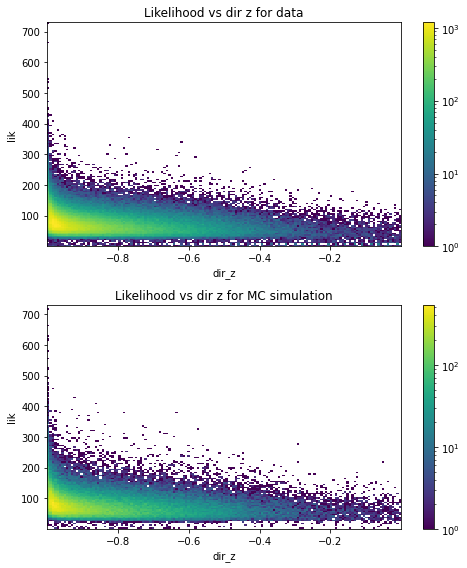

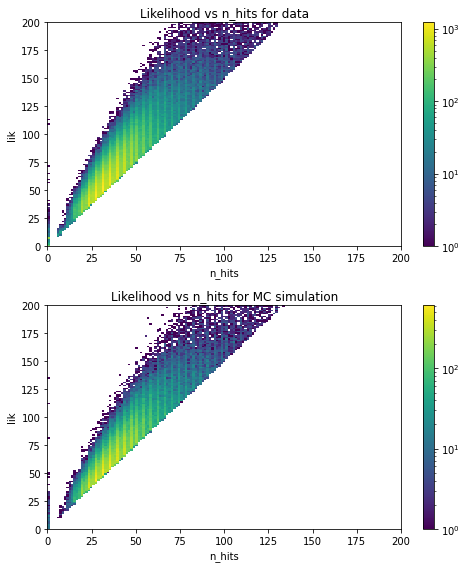

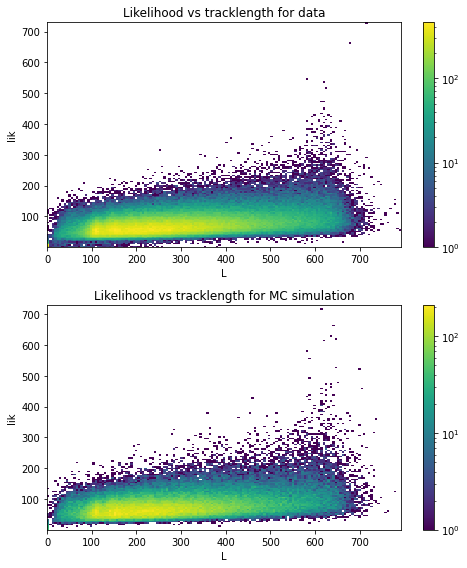

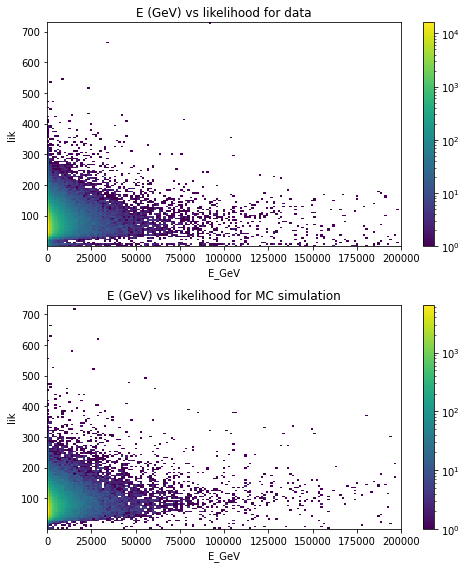

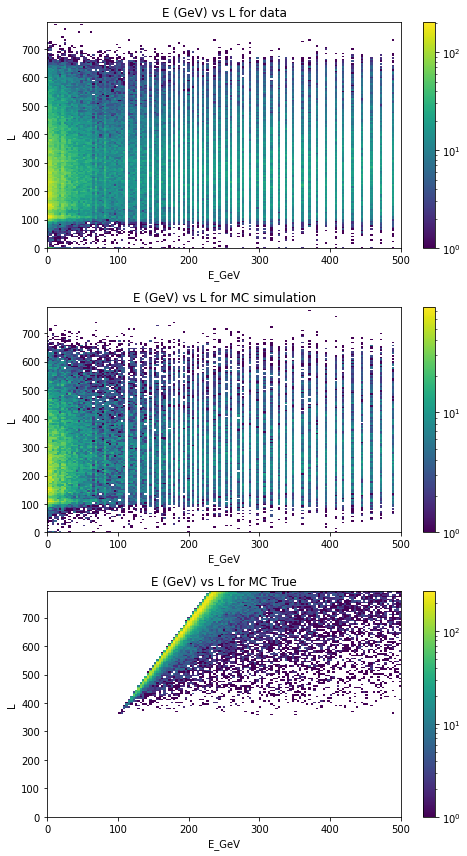

In [43]:
    #   Different plots 2D

    plot2var_subplot([df_1,df_2],'dir_z','lik',title=['Likelihood vs dir z for data','Likelihood vs dir z for MC simulation'])
    plot2var_subplot([df_1,df_2],'n_hits','lik',var1_min=0,var1_max=200,var2_min=0,var2_max=200,title=['Likelihood vs n_hits for data','Likelihood vs n_hits for MC simulation'])
    plot2var_subplot([df_1,df_2],'L','lik',title=['Likelihood vs tracklength for data','Likelihood vs tracklength for MC simulation'])
    plot2var_subplot([df_1,df_2],'E_GeV','lik',var1_min=0,var1_max=2e5,title=['E (GeV) vs likelihood for data','E (GeV) vs likelihood for MC simulation'])
 
    plot2var_subplot([df_1,df_2,df_3],'E_GeV','L',var1_min=0,var1_max=500,title=['E (GeV) vs L for data','E (GeV) vs L for MC simulation','E (GeV) vs L for MC True'])

    plt.show()

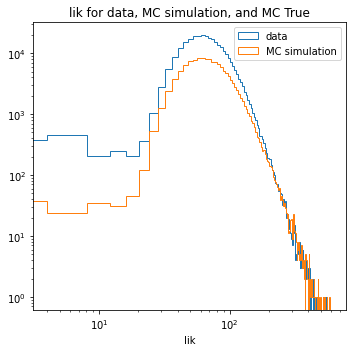

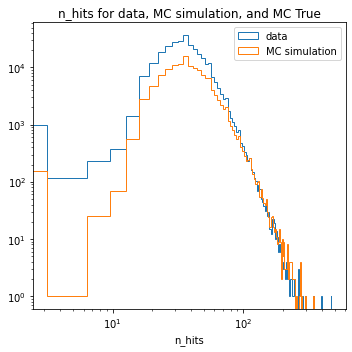

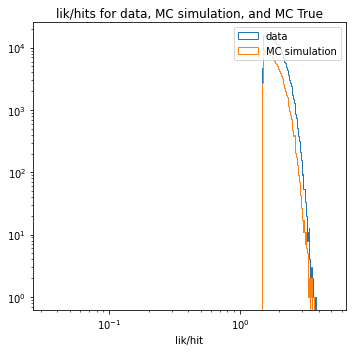

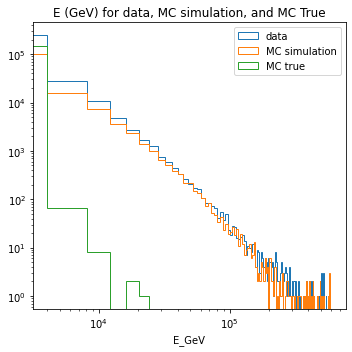

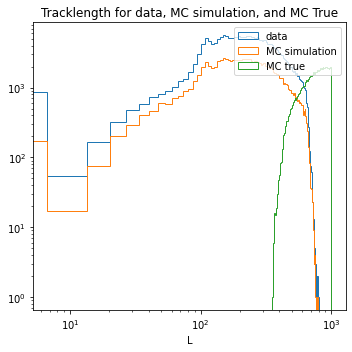

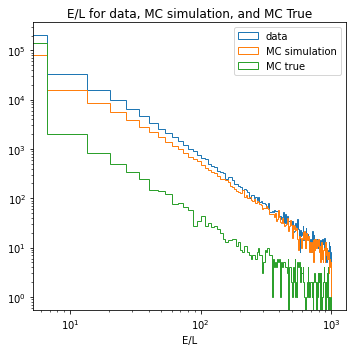

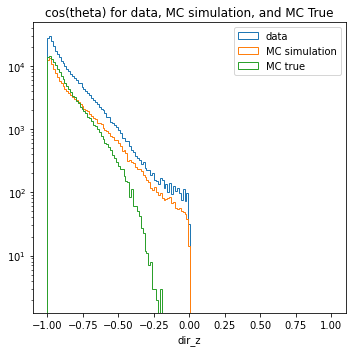

In [44]:
    #   Simple histograms
    
    plot1var_overplot([df_1,df_2],var='lik',var_min=0,var_max=600,logscale_x=True,logscale_y=True,title='lik for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot([df_1,df_2],'n_hits',logscale_x=True,logscale_y=True,title='n_hits for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot([df_1,df_2],'lik/hit',var_min=0,var_max=5,logscale_x=True,logscale_y=True,title='lik/hits for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])

    plot1var_overplot([df_1,df_2,df_3],var='E_GeV',var_min=0,var_max=0.6e6,logscale_x=True,logscale_y=True,title='E (GeV) for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot([df_1,df_2,df_3],var='L',var_min=0,var_max=1000,logscale_x=True,logscale_y=True,title='Tracklength for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot([df_1,df_2,df_3],var='E/L',var_min=0,var_max=1000,logscale_x=True,logscale_y=True,title='E/L for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
    plot1var_overplot([df_1,df_2,df_3],var='dir_z',var_min=-1,var_max=1,logscale_y=True,title='cos(theta) for data, MC simulation, and MC True',var_names=['data','MC simulation','MC true'])
 

    plt.show()